In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# train.csv - the training set
# test.csv - the test set
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


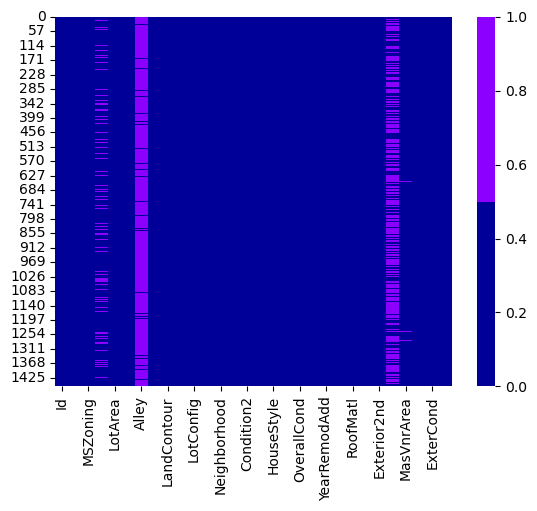

In [2]:
cols = df.columns[0:30] # первые 30 колонок

colors = ['#000099', '#8b00ff'] 
a = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

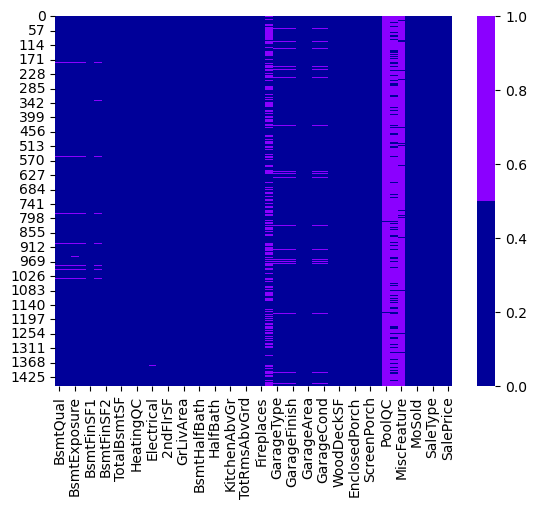

In [3]:
cols = df.columns[30:]

colors = ['#000099', '#8b00ff'] 
a = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

In [4]:
# отбрасываем неуникальные строки
df_dedupped = df.drop('Id', axis=1).drop_duplicates()
# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)

(1460, 81)
(1460, 80)


поскольку дубликатов нет, перейдем к подробному рассмотрению двух целевых колонок
извлечь площадь и цену  
LotArea - Площадь участка: Размер участка в квадратных футах  
SalePrice - цена  

Информация о колонках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LotArea    1460 non-null   int64
 1   SalePrice  1460 non-null   int64
dtypes: int64(2)
memory usage: 22.9 KB
None

Первые 5 строк:
   LotArea  SalePrice
0     8450     208500
1     9600     181500
2    11250     223500
3     9550     140000
4    14260     250000

Пропущенные значения:
LotArea      0
SalePrice    0
dtype: int64


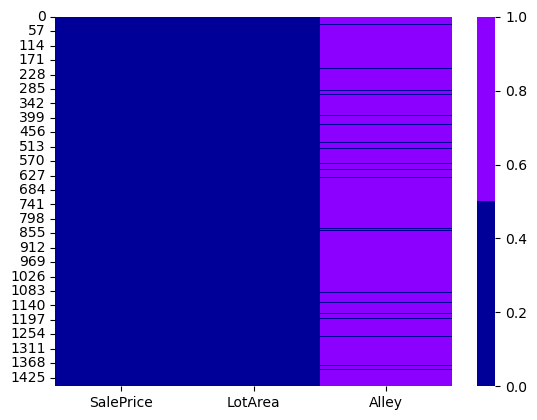

In [5]:

cols = ['SalePrice', 'LotArea','Alley']


# Сначала проверим данные
print("Информация о колонках:")
print(df[['LotArea', 'SalePrice']].info())

print("\nПервые 5 строк:")
print(df[['LotArea', 'SalePrice']].head())

print("\nПропущенные значения:")
print(df[['LotArea', 'SalePrice']].isnull().sum())

# Если все в порядке, строим тепловую карту пропусков
colors = ['#000099', '#8b00ff'] 
a = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

# преобразуем данные в кв.м. и тыс.долларов

In [6]:
# Создаём новые столбцы вместо перезаписи
df['LotArea_sqm'] = df['LotArea'] * 0.09290304
df['SalePrice_thousands'] = df['SalePrice'] / 1000

# Проверим несколько примеров
print(df[['LotArea', 'LotArea_sqm', 'SalePrice', 'SalePrice_thousands']].head(3))

   LotArea  LotArea_sqm  SalePrice  SalePrice_thousands
0     8450   785.030688     208500                208.5
1     9600   891.869184     181500                181.5
2    11250  1045.159200     223500                223.5


## Исследуем выбросы

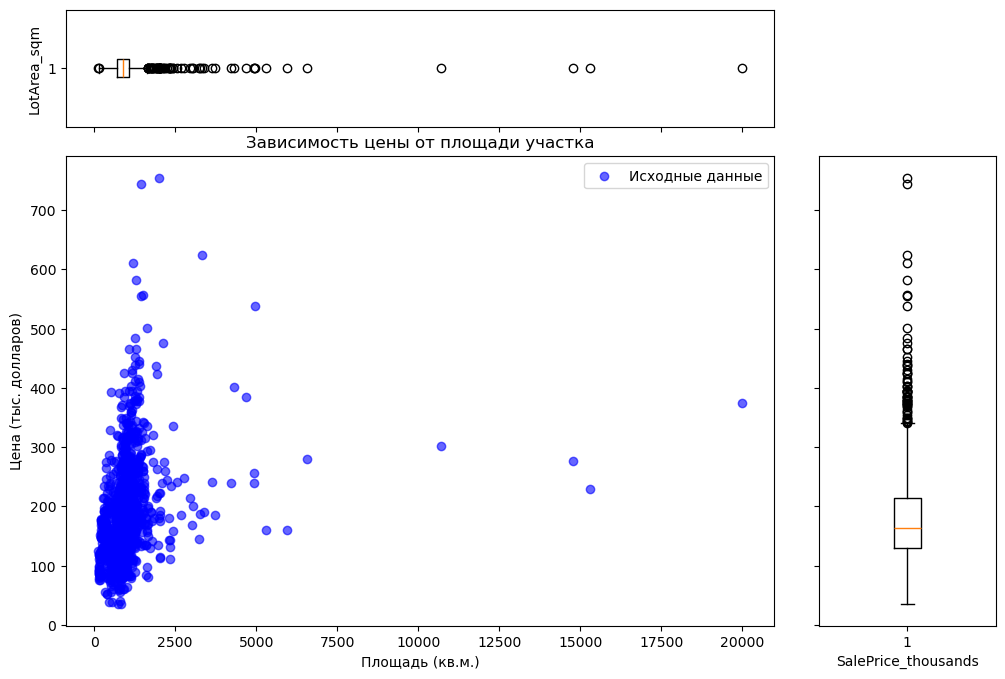

In [7]:
# Визуализация данных и линии регрессии
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.1, wspace=0.1)

# scatter plot
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(df['LotArea_sqm'], df['SalePrice_thousands'], color='blue', alpha=0.6, label='Исходные данные')
ax_scatter.set_xlabel('Площадь (кв.м.)')
ax_scatter.set_ylabel('Цена (тыс. долларов)')
ax_scatter.set_title('Зависимость цены от площади участка')
ax_scatter.legend()

# Boxplot для 'LotArea_sqm' (сверху)
ax_box_top = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_box_top.boxplot(df['LotArea_sqm'], vert=False)
ax_box_top.set_ylabel('LotArea_sqm')
ax_box_top.tick_params(axis='x', labelbottom=False) 

# Boxplot для SalePrice_thousands (справа)
ax_box_right = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_box_right.boxplot(df['SalePrice_thousands'], vert=True)
ax_box_right.set_xlabel('SalePrice_thousands')
ax_box_right.tick_params(axis='y', labelleft=False)

plt.show()

## на графике видно, что некотрые квартиры имеют площадь сверх 200.000 футов (20.000 м.кв.), но их стоимость не выше средней, и наоборот, некоторые квартиры имеют запредельную стоимость при ординарной площади.

In [8]:
Q1 = df['LotArea_sqm'].quantile(0.25)
Q3 = df['LotArea_sqm'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers_mask = (df['LotArea_sqm'] < lower_bound) | (df['LotArea_sqm'] > upper_bound)


num_outliers = outliers_mask.sum()
print(f"Количество выбросов в 'LotArea_sqm': {num_outliers}")


outliers_data = df[outliers_mask][['LotArea_sqm', 'SalePrice_thousands', 'Street', 'YrSold', 'SaleType', 'SaleCondition']]


print("\nВыбросы отсортированные по площади:")
print(outliers_data.sort_values('LotArea_sqm', ascending=False))


Количество выбросов в 'LotArea_sqm': 34

Выбросы отсортированные по площади:
       LotArea_sqm  SalePrice_thousands Street  YrSold SaleType SaleCondition
313   19996.914845              375.000   Pave    2009       WD        Normal
335   15297.414566              228.950   Grvl    2008       WD        Normal
249   14771.583360              277.000   Pave    2007       WD        Normal
706   10697.692153              302.000   Pave    2007       WD        Normal
451    6573.912013              280.000   Pave    2006       WD        Normal
1298   5935.296516              160.000   Pave    2008      New       Partial
1396   5314.053888              160.000   Pave    2010       WD        Normal
769    4970.684252              538.000   Pave    2010       WD        Normal
457    4944.950110              256.000   Pave    2008       WD        Normal
384    4933.801745              240.000   Pave    2007       WD        Normal
53     4670.328724              385.000   Pave    2006       WD  

In [9]:

df_cleaned1 = df[~outliers_mask]  # знак ~ означает "НЕ"

print("Размеры до очистки:", df.shape)
print("Размеры после очистки:", df_cleaned1.shape)
print("Удалено строк:", len(df) - len(df_cleaned1))

Размеры до очистки: (1460, 83)
Размеры после очистки: (1426, 83)
Удалено строк: 34


In [10]:
Q1 = df_cleaned1['SalePrice_thousands'].quantile(0.25)
Q3 = df_cleaned1['SalePrice_thousands'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers_mask = (df_cleaned1['SalePrice_thousands'] < lower_bound) | (df_cleaned1['SalePrice_thousands'] > upper_bound)


num_outliers = outliers_mask.sum()
print(f"Количество выбросов в SalePrice_thousands: {num_outliers}")


outliers_data = df_cleaned1[outliers_mask][['SalePrice_thousands','LotArea_sqm', 'Street', 'YrSold', 'SaleType', 'SaleCondition']]


print("\nВыбросы отсортированные по цене:")
print(outliers_data.sort_values('SalePrice_thousands', ascending=False))

Количество выбросов в SalePrice_thousands: 11

Выбросы отсортированные по цене:
      SalePrice_thousands  LotArea_sqm Street  YrSold SaleType SaleCondition
691               755.000  2000.666966   Pave    2007       WD        Normal
1182              745.000  1451.424194   Pave    2007       WD       Abnorml
898               611.657  1200.214374   Pave    2010      New       Partial
803               582.933  1290.516129   Pave    2009      New       Partial
1046              556.581  1491.651210   Pave    2006      New       Partial
440               555.000  1433.586810   Pave    2009       WD        Normal
178               501.837  1618.649666   Pave    2009      New       Partial
798               485.000  1255.863295   Pave    2009      New       Partial
185               475.000  2132.124768   Pave    2006       WD        Normal
1373              466.500  1059.094656   Pave    2007       WD        Normal
1243              465.000  1290.516129   Pave    2006      New       Part

In [11]:
# Создаем новый DataFrame БЕЗ выбросов
df_cleaned2 = df_cleaned1[~outliers_mask]  # знак ~ означает "НЕ"

print("Размеры до очистки:", df_cleaned1.shape)
print("Размеры после очистки:", df_cleaned2.shape)
print("Удалено строк:", len(df_cleaned1) - len(df_cleaned2))

Размеры до очистки: (1426, 83)
Размеры после очистки: (1415, 83)
Удалено строк: 11


исходя из представленной информации о выбросах, нельзя сказать, что высокая стоимость или большая площадь обусловлены какими-то параметрами. Остается загадкой, почему эти квартиры были проданы, поэтому я считаю рацилональным решение отбросить эти выбросы.

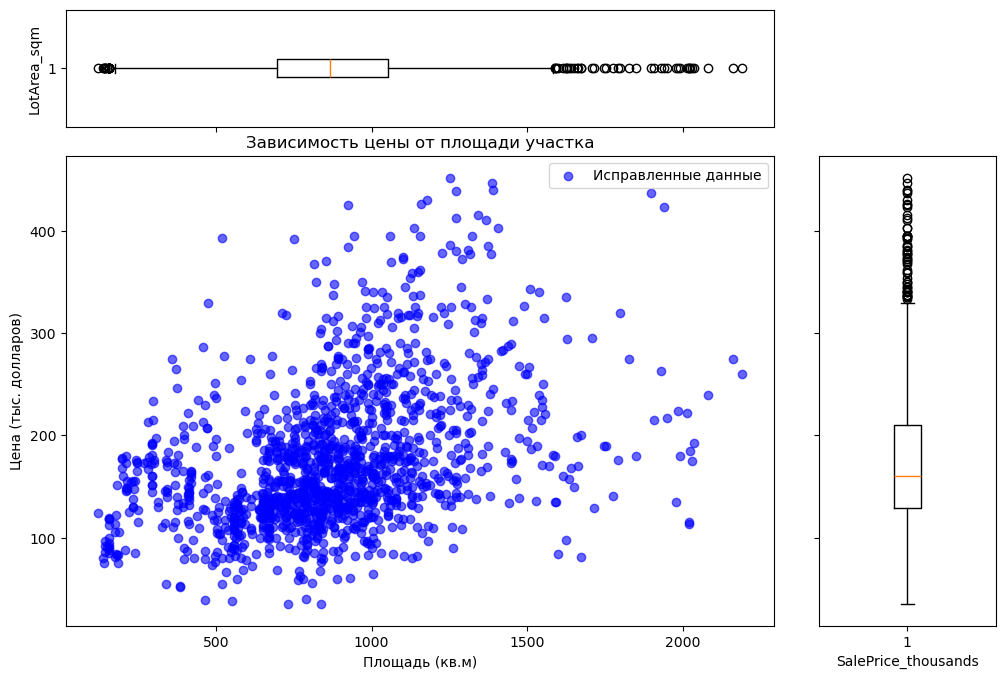

In [12]:
# Визуализация данных и линии регрессии
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.1, wspace=0.1)

# scatter plot
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(df_cleaned2['LotArea_sqm'], df_cleaned2['SalePrice_thousands'], color='blue', alpha=0.6, label='Исправленные данные')
ax_scatter.set_xlabel('Площадь (кв.м)')
ax_scatter.set_ylabel('Цена (тыс. долларов)')
ax_scatter.set_title('Зависимость цены от площади участка')
ax_scatter.legend()

# Boxplot для 'LotArea_sqm' (сверху)
ax_box_top = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_box_top.boxplot(df_cleaned2['LotArea_sqm'], vert=False)
ax_box_top.set_ylabel('LotArea_sqm')
ax_box_top.tick_params(axis='x', labelbottom=False) 

# Boxplot для SalePrice_thousands (справа)
ax_box_right = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_box_right.boxplot(df_cleaned2['SalePrice_thousands'], vert=True)
ax_box_right.set_xlabel('SalePrice_thousands')
ax_box_right.tick_params(axis='y', labelleft=False)

plt.show()

когда убрали экстримальные выбросы и убедились, что пропуусков нет, можно приступать к следующему этапу.

In [13]:
data = df_cleaned2[['SalePrice_thousands', 'LotArea_sqm']].copy()
data.head()

,SalePrice_thousands,LotArea_sqm
0,208.5,785.030688
1,181.5,891.869184
2,223.5,1045.159200
3,140.0,887.224032
4,250.0,1324.797350


In [14]:
# Разделяем данные на признаки (X) и целевые значения (y)

X = data[['LotArea_sqm']].values
#площадь квартиры


Y = data[['SalePrice_thousands']].values
#цена


print(X.shape)
print(Y.shape)
print(Y)

(1415, 1)
(1415, 1)
[[208.5  ]
 [181.5  ]
 [223.5  ]
 ...
 [266.5  ]
 [142.125]
 [147.5  ]]


●     X1 —
это площадь квартиры (независимая переменная).



●     y1 —
это цена квартиры (зависимая переменная).

# Формирование матрицы признаков и целевой переменной

In [15]:
# Добавляем столбец единиц для свободного члена (w_0)

X = np.column_stack([np.ones(len(X)), X])
print(X)

[[1.00000000e+00 7.85030688e+02]
 [1.00000000e+00 8.91869184e+02]
 [1.00000000e+00 1.04515920e+03]
 ...
 [1.00000000e+00 8.40029288e+02]
 [1.00000000e+00 9.02738840e+02]
 [1.00000000e+00 9.23177508e+02]]


согласно дипсик, это научная нотация - способ отображения чисел. на вормат хранения чисел не влияет  
# Реализация метода наименьших квадратов

In [16]:
# Вычисляем коэффициенты методом наименьших квадратов

X_T = X.T
#транспонируем матрицу X

X_T_X = X_T.dot(X)
# X^T * X

X_T_y = X_T.dot(Y)
# X^T * y

# Решаем нормальные уравнения

w = np.linalg.inv(X_T_X).dot(X_T_y)

# Коэффициенты

w0, w1 = w[0], w[1]
comm1 = (f"w0: {w0[0]:.2f}, w1: {w1[0]:.2f}")
print(comm1)

w0: 101.58, w1: 0.09


# Оценка качества модели
## Среднеквадратичная ошибка (MSE)

In [17]:
# Предсказания модели

y_pred = X.dot(w)

# Вычисление MSE

mse = np.mean((Y - y_pred)**2)
comm2 = (f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(comm2)

Среднеквадратичная ошибка (MSE): 4088.75


#  Коэффициент детерминации R2

In [18]:
# Вычисление R^2

sst = np.sum((Y - np.mean(Y))**2) # суммарная вариация

sse = np.sum((Y - y_pred)**2) # сумма квадратов ошибок

r2 = 1 - sse / sst
comm3 = (f"Коэффициент детерминации (R^2):{r2:.2f}")
print(comm3)

Коэффициент детерминации (R^2):0.16


# Визуализация результатов

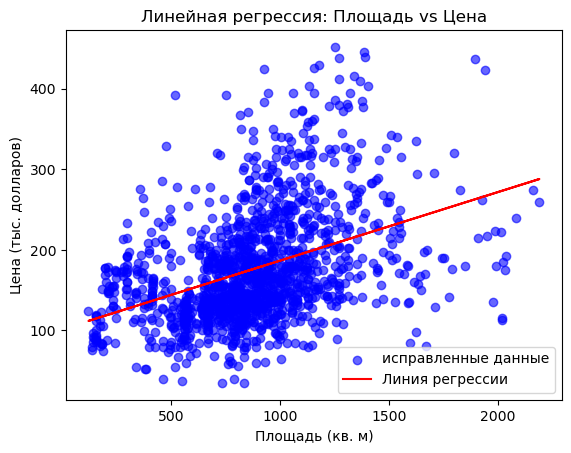

In [19]:
# Визуализация данных и линии регрессии

plt.scatter(X[:, 1], Y, color='blue', alpha=0.6, label='исправленные данные') # график точек
plt.plot(X[:, 1], y_pred, color='red', label='Линия регрессии') # линия регрессии
plt.xlabel('Площадь (кв. м)')
plt.ylabel('Цена (тыс. долларов)')
plt.title('Линейная регрессия: Площадь vs Цена')
plt.legend()
plt.show()

## как бы выглядела линейная регрессия для Значений до обработки

было: w0: 158.84, w1: 0.02
стало: w0: 101.58, w1: 0.09
Было: Среднеквадратичная ошибка (MSE): 5867.75
стало: Среднеквадратичная ошибка (MSE): 4088.75
Было: Коэффициент детерминации (R^2):0.07
Стало: Коэффициент детерминации (R^2):0.16


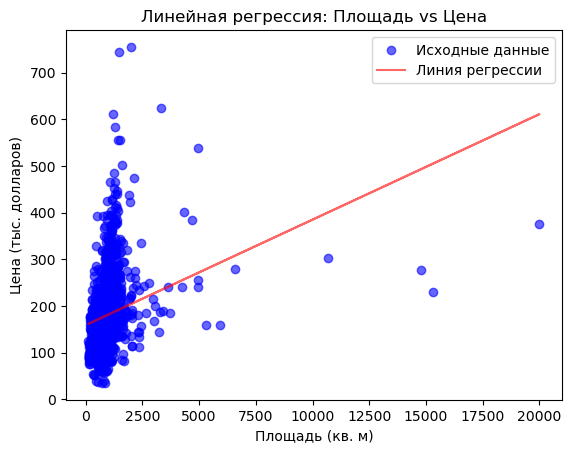

In [20]:
data = df[['SalePrice_thousands', 'LotArea_sqm']].copy()
data.head()
X1 = data[['LotArea_sqm']].values
Y1 = data[['SalePrice_thousands']].values
X1 = np.column_stack([np.ones(len(X1)), X1])
X1_T = X1.T
X1_T_X1 = X1_T.dot(X1)
X1_T_Y1 = X1_T.dot(Y1)
w = np.linalg.inv(X1_T_X1).dot(X1_T_Y1)
w0, w1 = w[0], w[1]
print(f"было: w0: {w0[0]:.2f}, w1: {w1[0]:.2f}")
print(f"стало: {comm1}")
Y1_pred = X1.dot(w)
mse = np.mean((Y1 - Y1_pred)**2)
print(f"Было: Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"стало: {comm2}")
sst = np.sum((Y1 - np.mean(Y1))**2) # суммарная вариация
sse = np.sum((Y1 - Y1_pred)**2) # сумма квадратов ошибок
r2 = 1 - sse / sst
print(f"Было: Коэффициент детерминации (R^2):{r2:.2f}")
print(f"Стало: {comm3}")
plt.scatter(X1[:, 1], Y1, color='blue', alpha=0.6, label='Исходные данные') # график точек
plt.plot(X1[:, 1], Y1_pred, color='red', alpha=0.6, label='Линия регрессии') # линия регрессии
plt.xlabel('Площадь (кв. м)')
plt.ylabel('Цена (тыс. долларов)')
plt.title('Линейная регрессия: Площадь vs Цена')
plt.legend()
plt.show()

## Сравнение

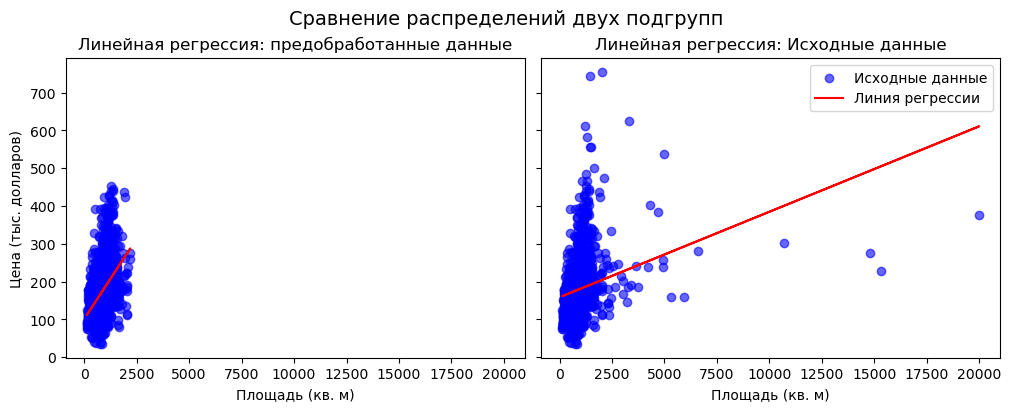

In [21]:
fig, axs = plt.subplots(
    1,  # 1 строка
    2,  # 2 столбца
    figsize=(10, 4), sharey=True, sharex=True, constrained_layout=True
)

axs[0].scatter(X[:, 1], Y, color='blue', alpha=0.6, label='после предобработки') # график точек
axs[0].plot(X[:, 1], y_pred, color='red', label='Линия регрессии') # линия регрессии
axs[0].set_title('Линейная регрессия: предобработанные данные')
axs[0].set_xlabel('Площадь (кв. м)')
axs[0].set_ylabel('Цена (тыс. долларов)')


axs[1].scatter(X1[:, 1], Y1, color='blue', alpha=0.6, label='Исходные данные') # график точек
axs[1].plot(X1[:, 1], Y1_pred, color='red', label='Линия регрессии') # линия регрессии
axs[1].set_title('Линейная регрессия: Исходные данные')
axs[1].set_xlabel('Площадь (кв. м)')


plt.legend()
fig.suptitle("Сравнение распределений двух подгрупп", fontsize=14)
plt.show()

по графикам и данным видно, что выбросы влияли на предсказания модели, и без них модель стала точнее.